#  Pawnee Fire analysis

The Pawnee Fire was a large wildfire that burned in Lake County, California. The fire started on June 23, 2018 and burned a total of 15,185 acres (61 km2) before it was fully contained on July 8, 2018.


![](img/pawneefire.jpg)

## Remote Sensing using Sentinel-2 layer

In [1]:
from arcgis import GIS
gis = GIS(profile='plenary_deldev_profile')

For this analysis, we will be using Sentinel-2 imagery from the Living Atlas.

Sentinel-2 is an Earth observation mission developed by ESA as part of the Copernicus Programme to perform terrestrial observations in support of services such as forest monitoring, land cover changes detection, and natural disaster management.

<Item title:"Sentinel-2 Views" type:Imagery Layer owner:esri>
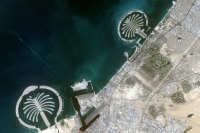

In [2]:
sentinel_item = gis.content.search('Sentinel-2 Views', outside_org=True)[0]
sentinel_item

### Select before and after rasters

In [3]:
import arcgis

sentinel = sentinel_item.layers[0]
aoi = {'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
 'xmax': -13643017.100720055,
 'xmin': -13652113.10708598,
 'ymax': 4739654.477447927,
 'ymin': 4731284.622850712}
arcgis.env.analysis_extent = aoi
sentinel.extent = aoi

In [4]:
import pandas as pd
from datetime import datetime

selected = sentinel.filter_by(where="acquisitiondate BETWEEN timestamp '2018-06-15 00:00:00' AND timestamp '2018-06-24 19:59:59'",
                              geometry=arcgis.geometry.filters.intersects(aoi))

df = selected.query(out_fields="AcquisitionDate, Tile_ID, CloudCover", order_by_fields="AcquisitionDate").df
df['acquisitiondate'] = pd.to_datetime(df['acquisitiondate'], unit='ms')
df.tail(40)

,acquisitiondate,cloudcover,objectid,shape_Area,shape_Length,tile_id,SHAPE
0,2018-06-17 19:02:28,0.1070,2686387,1.214547e+10,446919.588256,20180617T224132_10SEJ_0,"{'rings': [[[-13599954.1142, 4730228.964000002..."
1,2018-06-17 19:13:35,0.0398,2686843,4.138418e+09,271266.855576,20180618T001031_10SEJ_1,"{'rings': [[[-13634891.7136, 4731760.155000001..."
2,2018-06-19 19:03:34,0.0273,2701464,1.089364e+10,438058.126931,20180619T190334_10SEJ_0,"{'rings': [[[-13667279.6085, 4773934.774300002..."
3,2018-06-22 19:04:33,0.0000,2750251,1.402370e+10,486152.331987,20180622T190432_10SEJ_0,"{'rings': [[[-13596402.5766, 4745349.801899999..."
4,2018-06-24 19:01:08,0.0000,2800097,1.991829e+10,560634.860343,20180624T190108_10SEJ_0,"{'rings': [[[-13549971.4055, 4828395.097300000..."


In [5]:
prefire = sentinel.filter_by('OBJECTID=2750251') # 2017-07-01
midfire = sentinel.filter_by('OBJECTID=2800097') # 2017-07-24 

## Visual Assessment

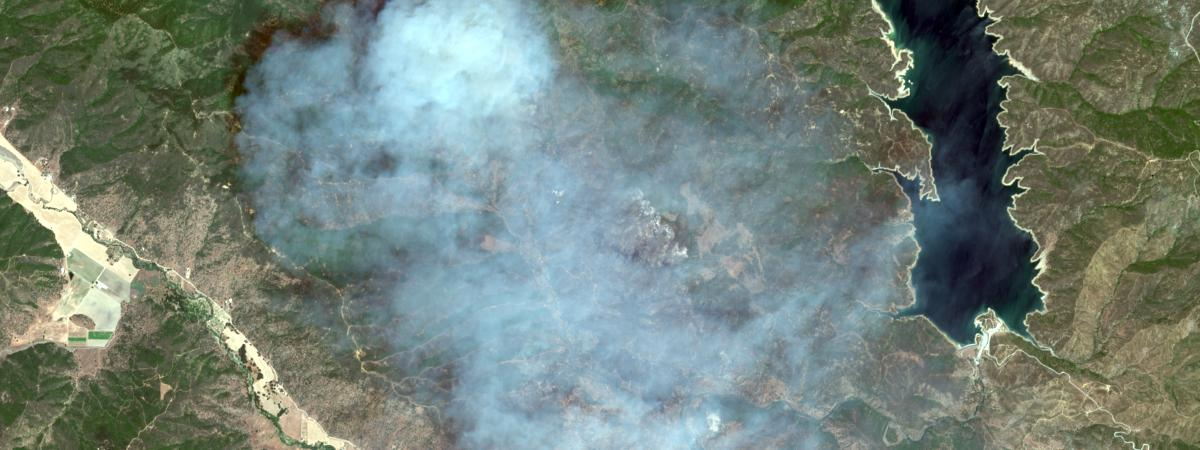

In [6]:
from arcgis.raster.functions import *

truecolor = apply(midfire, 'Natural Color with DRA')
truecolor

### Visualize Burn Scars

Extract the [12, 11, 4] bands to improve visibility of fire and burn scars. This band combination pushes further into the SWIR range of the electromagnetic spectrum, where there is less susceptibility to smoke and haze generated by a burning fire.

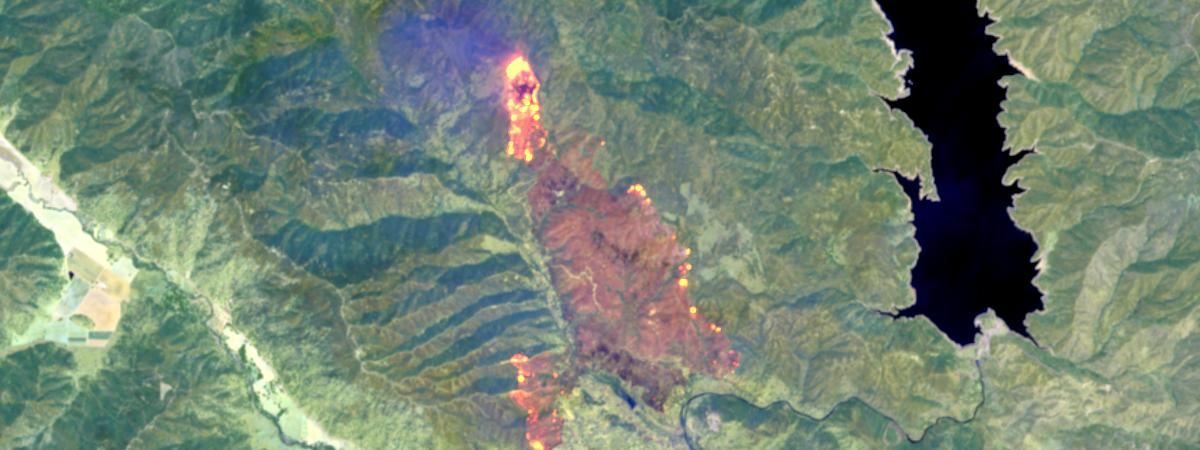

In [7]:
extract_band(midfire, [12,11,4])

For comparison, the same area before the fire started shows no burn scar.

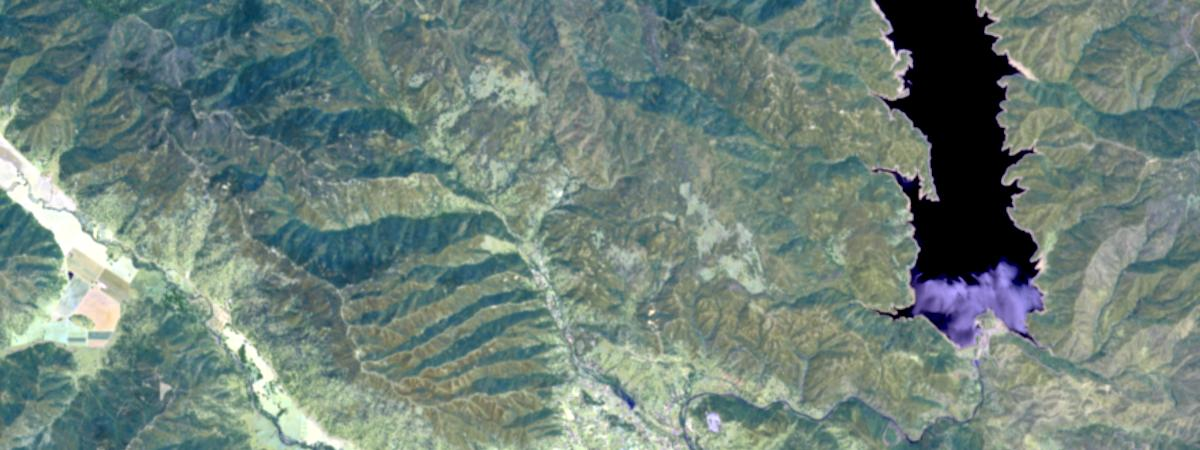

In [8]:
extract_band(prefire, [12,11,4])

## Quantitative Assessment

The **Normalized Burn Ratio (NBR)** can be used to delineate the burnt areas and identify the severity of the fire. 

The formula for the NBR is very similar to that of NDVI except that it uses near-infrared band 9 and the short-wave infrared band 13:
\begin{align}
{\mathbf{NBR}} = \frac{\mathbf{B9} - \mathbf{B13}}{\mathbf{B9} + \mathbf{B13} + \mathbf{WS}} \\   
\end{align}

The NBR equation was designed to be calcualted from reflectance, but it can be calculated from radiance and digital_number_(dn) with changes to the burn severity table below. The WS parameter is used for water suppression, and is typically 2000. 

For a given area, NBR is calculated from an image just prior to the burn and a second NBR is calculated for an image immediately following the burn. Burn extent and severity is judged by taking the difference between these two index layers:

\begin{align}
{\Delta \mathbf{NBR}} = \mathbf{NBR_{prefire}} - \mathbf{NBR_{postfire}} \\   
\end{align}

The meaning of the ∆NBR values can vary by scene, and interpretation in specific instances should always be based on some field assessment. However, the following table from the USGS FireMon program can be useful as a first approximation for interpreting the NBR difference:


| \begin{align}{\Delta \mathbf{NBR}}  \end{align}      | Burn Severity |
| ------------- |:-------------:|
| 0.1 to 0.27   | Low severity burn |
| 0.27 to 0.44  | Medium severity burn |
| 0.44 to 0.66 | Moderate severity burn |
| > 0.66 | High severity burn |

[Source: http://wiki.landscapetoolbox.org/doku.php/remote_sensing_methods:normalized_burn_ratio]

### Use Band Arithmetic and Map Algebra 

In [9]:
nbr_prefire  = band_arithmetic(prefire, "(b9 - b13) / (b9 + b13 + 2000)")
nbr_postfire = band_arithmetic(midfire, "(b9 - b13) / (b9 + b13 + 2000)")

nbr_diff = nbr_prefire - nbr_postfire

In [10]:
burnt_areas = colormap(remap(nbr_diff, 
                             input_ranges=[0.1,  0.27,  # low severity 
                                           0.27, 0.44,  # medium severity
                                           0.44, 0.66,  # moderate severity
                                           0.66, 1.00], # high severity burn
                             output_values=[1, 2, 3, 4],                    
                             no_data_ranges=[-1, 0.1], astype='u8'), 
                       colormap=[[4, 0xFF, 0xC3, 0], [3, 0xFA, 0x8E, 0], [2, 0xF2, 0x55, 0], 
                                 [1, 0xE6, 0,    0]])

In [20]:
burnt_areas.draw_graph()

<img src="./img/pawnee-fire-graph.jpg" />

### Area calculation

In [12]:
pixx = (aoi['xmax'] - aoi['xmin']) / 1200.0
pixy = (aoi['ymax'] - aoi['ymin']) / 450.0

res = burnt_areas.compute_histograms(aoi, pixel_size={'x':pixx, 'y':pixy})

numpix = 0
histogram = res['histograms'][0]['counts'][1:]
for i in histogram:
    numpix += i

### Report burnt area

In [13]:
from IPython.display import HTML
sqmarea = numpix * pixx * pixy # in sq. m
acres = 0.00024711 * sqmarea   # in acres

HTML('<h3>Fire has consumed <font color="red">{:,} acres</font>  till {}</h3>.' \
     .format(int(acres), df.iloc[-1]['acquisitiondate'].date()))

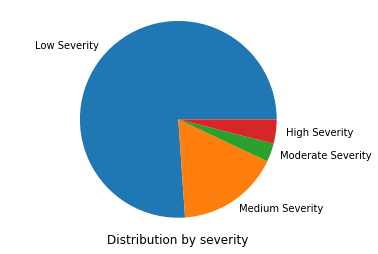

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.title('Distribution by severity', y=-0.1)
plt.pie(histogram, labels=['Low Severity', 'Medium Severity', 
                           'Moderate Severity', 'High Severity'])
plt.axis('equal')

### Visualize burnt areas

In [17]:
firemap = gis.map()
firemap.extent = aoi
firemap

<img src="./img/pawnee-fire-inmem-raster.jpg" width=100% />

In [16]:
firemap.add_layer([truecolor, burnt_areas])

## Raster to Feature layer conversion

Use Raster Analytics and Geoanalytics to convert the burnt area raster to a feature layer. The `to_features()` method converts the raster to a feature layer and `create_buffers()` fills holes in the features and dissolves them to output one feature that covers the extent of the Thomas Fire.

#### Access Portal

In [14]:
#gis = GIS("https://datasciencedev.esri.com/portal", "rjackson", "admin123", verify_cert=False)
portal = GIS("https://python.playground.esri.com/portal", "arcgis_python", "amazing_arcgis_123") 

fire = portal.content.search('PawneeFireArea', 'Feature Layer')[0]
fire

<Item title:"PawneeFireArea" type:Feature Layer Collection owner:arcgis_python>

### Convert and Buffer Data

In [31]:
from arcgis.geoanalytics.use_proximity import create_buffers

fire_item = burnt_areas.to_features(output_name='Pawnee_Fire_boundary_output_tst')

fire_layer = fire_item.layers[0]

In [30]:
fire = create_buffers(fire_layer, 100, 'Meters', dissolve_option='All', 
                      multipart=True, output_name='PawneeFireAreaTst')

## Visualize feature layer

In [19]:
vectormap = gis.map()
vectormap.basemap = 'dark-gray'
vectormap.extent  = aoi
vectormap.add_layer(fire)
vectormap

<img src="./img/pawnee-fire-vectormap.jpg"/>

## Impact Assessment

### Assess human impact

In [29]:
from arcgis.geoenrichment import enrich
from arcgis.geometry import filters
from arcgis.features import GeoAccessor, GeoSeriesAccessor
import pandas as pd

In [30]:
sdf = pd.DataFrame.spatial.from_layer(fire.layers[0])

gis = GIS(profile='deldev')

fire_geometry = sdf.iloc[0].SHAPE
sa_filter = filters.intersects(geometry=fire_geometry, 
                               sr=fire_geometry['spatialReference'])

In [31]:
def age_pyramid(df):
    import warnings
    import seaborn as sns
    import matplotlib.pyplot as plt

    %matplotlib inline
    warnings.simplefilter(action='ignore', category=FutureWarning)
    pd.options.mode.chained_assignment = None 
    plt.style.use('ggplot')

    df = df[[x for x in impacted_people.columns if 'MALE' in x or 'FEM' in x]]
    sf = pd.DataFrame(df.sum())
    age = sf.index.str.extract('(\d+)').astype('int64')
    f = sf[sf.index.str.startswith('FEM')]
    m = sf[sf.index.str.startswith('MALE')]
    sf = sf.reset_index(drop = True)
    f = f.reset_index(drop = True)
    m = m.reset_index(drop = True)
    sf['age'] = age
    f["age"] = age
    m["age"] = age
    f = f.sort_values(by='age', ascending=False).set_index('age')
    m = m.sort_values(by='age', ascending=False).set_index('age')
    

    popdf = pd.concat([f, m], axis=1)
    popdf.columns = ['F', 'M']
    popdf['agelabel'] = popdf.index.map(str) + ' - ' + (popdf.index+4).map(str)
    popdf.M = -popdf.M
    
    sns.barplot(x="F", y="agelabel", color="#CC6699", label="Female", data=popdf, edgecolor='none')
    sns.barplot(x="M",  y="agelabel", color="#008AB8", label="Male",   data=popdf,  edgecolor='none')
    plt.ylabel('Age group')
    plt.xlabel('Number of people');
    return plt;

### Age Pyramid of affected population

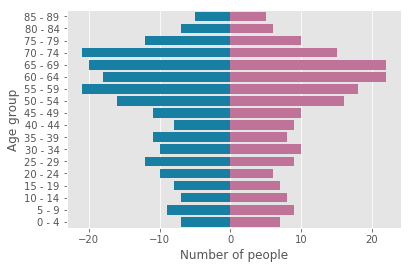

In [32]:
from arcgis.geoenrichment import enrich

impacted_people = enrich(sdf, 'Age')
age_pyramid(impacted_people)

![](img/wildfire_banner.jpg)